In [2]:
# A whole new big mess of a step...
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Model running via: {device}")

Model running via: cuda


4
16
torch.Size([20, 1])
torch.Size([20, 2])


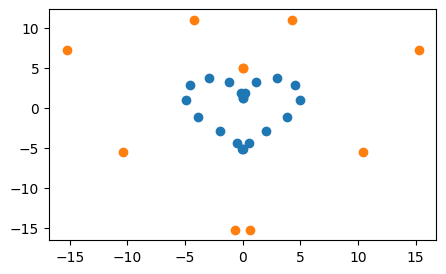

In [4]:
# Globally Shared Model(s) Parameters
lf_num_epochs = 500
hf_num_epochs = 700
MF_epochs = 300

hidden_dims = ([700, 700, 700, 700, 700, 700, 700, 700])
LF_training_size = 20
HF_training_size = 10



def HF(Z):
    xH = 16 * torch.sin(Z)**3
    yH = 13 * torch.cos(Z) - 5 * torch.cos(2*Z) - 2 * torch.cos(3*Z) - torch.cos(4*Z)
    return torch.cat([xH, yH], dim=1)

def LF(Z):
    xL = 5 * np.sin(Z)**3 
    yL = 4 * np.cos(Z) - 1.75 * np.cos(2*Z) - 0.75 * np.cos(3*Z) - 0.25 * np.cos(4*Z) 
    return torch.cat([xL, yL], dim=1)


Z = torch.linspace(0, 2*np.pi, 1000)[:,None]

# Model's total training/val/testing dataset
LF_TS = torch.linspace(0, 2*np.pi, LF_training_size)[:,None]
HF_TS = torch.linspace(0, 2*np.pi, HF_training_size)[:,None]


X_LF_train, X_LF_test, Y_LF_train, Y_LF_test = train_test_split(LF_TS, LF(LF_TS), test_size=0.8, shuffle=156)
X_HF_train, X_HF_test, Y_HF_train, Y_HF_test = train_test_split(HF_TS, HF(HF_TS), test_size=0.8, shuffle=156)

print(len(X_LF_train))
print(len(X_LF_test))

X_LF_train = LF_TS
X_HF_train = HF_TS

Y_LF_train = LF(LF_TS)
Y_HF_train = HF(HF_TS)


# Unpacking Example
xL, yL = torch.split(Y_LF_train, [1, 1], dim=1)
xH, yH = torch.split(Y_HF_train, [1, 1], dim=1)

plt.figure(figsize=(5,3))
plt.scatter(xL, yL)
plt.scatter(xH, yH)

# Transfering data to GPU for CUDA
X_LF_train = X_LF_train.to(device); Y_LF_train = Y_LF_train.to(device)
X_HF_train = X_HF_train.to(device); Y_HF_train = Y_HF_train.to(device)

print(X_LF_train.shape)
print(Y_LF_train.shape)

# Y = Y_LF_train[:, 0].reshape(-1, 1)
# print(Y.shape())

Low Fidelity Network

In [444]:
LF_input_dim = 1
LF_output_dim = 2

class LowFidelityNetwork(torch.nn.Module):
  def __init__(self, hidden_dims, LF_input_dim, LF_output_dim):
    super().__init__()
    self.fc1 = nn.Linear(LF_input_dim, hidden_dims[0])
    # self.bn1 = nn.BatchNorm1d(hidden_dims[0])
    self.fc2 = nn.Linear(hidden_dims[0], hidden_dims[1])
    self.fc3 = nn.Linear(hidden_dims[1], hidden_dims[2])
    self.fc4 = nn.Linear(hidden_dims[2], hidden_dims[3])
    self.fc5 = nn.Linear(hidden_dims[3], hidden_dims[4])
    self.fc6 = nn.Linear(hidden_dims[4], hidden_dims[5])
    self.fc7 = nn.Linear(hidden_dims[5], hidden_dims[6])
    self.fcEND = nn.Linear(hidden_dims[6], LF_output_dim)

  def forward(self, x):
    x = torch.relu(self.fc1(x))
    skip_connection = x
    # x = self.bn1(x)
    x = torch.relu(self.fc2(x))
    x = torch.relu(self.fc3(x))
    x = torch.relu(self.fc4(x))
    x = torch.relu(self.fc5(x))
    x = torch.relu(self.fc6(x))
    x = torch.relu(self.fc7(x))
    x = x + skip_connection
    x = self.fcEND(x)
    return x

LF_model = LowFidelityNetwork(hidden_dims, LF_input_dim, LF_output_dim).to(device)

for param in LF_model.parameters():
    param.requires_grad = True

In [445]:
LF_model.train()

# Training
LF_losses = [] 
val_losses = []
prev_loss = []
LF_loss = torch.zeros(1)

LF_batch_size = 175

# LF_loss criterion and optimizer
criterion = torch.nn.MSELoss().to(device)
optimizer = torch.optim.Adam(LF_model.parameters(), lr=0.0001) # weight_decay=1e-5


for epoch in range(lf_num_epochs):
    
    permutation = torch.randperm(X_LF_train.size()[0])
    
    for i in range(0,X_LF_train.size()[0], LF_batch_size):
        optimizer.zero_grad()

        indices = permutation[i:i+LF_batch_size]
        batch_x, batch_y = X_LF_train[indices], Y_LF_train[indices]
    
        prev_loss = LF_loss.item()
        outputs = LF_model.forward(batch_x)
        LF_loss = criterion(outputs,batch_y)
        LF_losses.append(LF_loss.item())
        LF_loss.backward()
        optimizer.step()

    if (epoch+1) % 600 == 0:
        print(f'Epoch [{epoch+1}/{hf_num_epochs}], Loss: {LF_loss.item():.4f}')

Epochs needed (out of 500): 500
LF Training Loss: 0.0007746180635876954


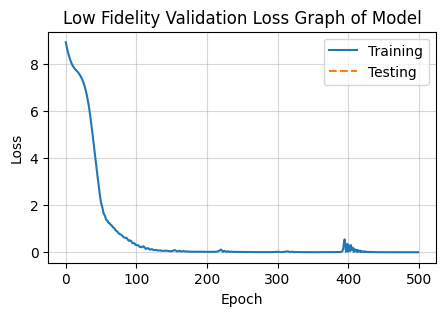

In [446]:
plt.figure(figsize=(5,3))
plt.plot(LF_losses, label = "Training")
plt.xlabel('Epoch')
plt.ylabel('LF_Loss')
plt.title('Low Fidelity Training Loss Graph of Model')

plt.plot(val_losses, "--" , label = "Testing")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Low Fidelity Validation Loss Graph of Model')
plt.grid(which='both', alpha=0.5)
plt.legend(loc='upper right')
# plt.show()

print(f"Epochs needed (out of {lf_num_epochs}): {len(LF_losses)}")
print(f"LF Training Loss: {LF_loss}")

High Fidelity Model

In [447]:
HF_input_dim = 1
HF_output_dim = 2

class HighFidelityNetwork(torch.nn.Module):
  def __init__(self, hidden_dims, HF_input_dim, HF_output_dim):
    super().__init__()
    self.fc1 = nn.Linear(HF_input_dim, hidden_dims[0])
    # self.bn1 = nn.BatchNorm1d(hidden_dims[0])
    self.fc2 = nn.Linear(hidden_dims[0], hidden_dims[1])
    self.fc3 = nn.Linear(hidden_dims[1], hidden_dims[2])
    self.fc4 = nn.Linear(hidden_dims[2], hidden_dims[3])
    self.fc5 = nn.Linear(hidden_dims[3], hidden_dims[4])
    self.fc6 = nn.Linear(hidden_dims[4], hidden_dims[5])
    self.fc7 = nn.Linear(hidden_dims[5], hidden_dims[6])
    self.fcEND = nn.Linear(hidden_dims[7], HF_output_dim)

  def forward(self, x):
    x = torch.relu(self.fc1(x))
    # x = self.bn1(x)
    x = torch.relu(self.fc2(x))
    x = torch.relu(self.fc3(x))
    x = torch.relu(self.fc4(x))
    x = torch.relu(self.fc5(x))
    x = torch.relu(self.fc6(x))
    x = torch.relu(self.fc7(x))
    x = self.fcEND(x)
    return x

HF_model = HighFidelityNetwork(hidden_dims, HF_input_dim, HF_output_dim).to(device)

for param in HF_model.parameters():
    param.requires_grad = True

In [448]:
HF_model.train()

# Training
HF_losses = [] 
val_losses = []
prev_loss = []
HF_loss = torch.zeros(1)

HF_batch_size = 45

# HF_loss criterion and optimizer
criterion = torch.nn.MSELoss().to(device)
optimizer = torch.optim.Adam(HF_model.parameters(), lr=0.00008, weight_decay=1e-6) # weight_decay=1e-5

for epoch in range(hf_num_epochs):
    
    permutation = torch.randperm(X_HF_train.size()[0])
    
    for i in range(0,X_HF_train.size()[0], HF_batch_size):
        optimizer.zero_grad()

        indices = permutation[i:i+HF_batch_size]
        batch_x, batch_y = X_HF_train[indices], Y_HF_train[indices]
    
        prev_loss = HF_loss.item()
        outputs = HF_model.forward(batch_x)
        HF_loss = criterion(outputs,batch_y)
        HF_losses.append(HF_loss.item())
        HF_loss.backward()
        optimizer.step()
        
    if (epoch+1) % 600 == 0:
        print(f'Epoch [{epoch+1}/{hf_num_epochs}], Loss: {HF_loss.item():.4f}')



Epoch [600/700], Loss: 0.0047


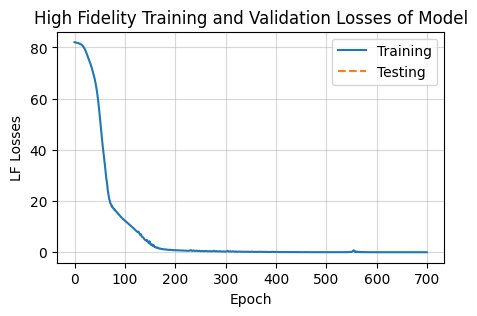

Epochs needed (out of 700): 700
HF Training Loss: 2.4094904802041128e-05


In [449]:
plt.figure(figsize=(5,3))
plt.plot(HF_losses, label = "Training")

plt.plot(val_losses, "--" , label = "Testing")
plt.xlabel('Epoch')
plt.ylabel('LF Losses')
plt.title('High Fidelity Training and Validation Losses of Model')
plt.legend(loc='upper right')
plt.grid(which='both', alpha=0.5)
plt.show()

# print(f"Error: {HF_average_percentage_error}")
print(f"Epochs needed (out of {hf_num_epochs}): {len(HF_losses)}")
print(f"HF Training Loss: {HF_loss}")

Multi-Fidelity Model

In [450]:
L1mean = LF_model(X_HF_train.to(device))

L2train = torch.hstack((X_HF_train, L1mean)) # think of the house price example (sqr feet, rooms, garden, etc.)
print(L2train.shape)

torch.Size([10, 3])


In [451]:
MF_input_dim = 3
MF_output_dim = 2

class MultiFidelityNetwork(torch.nn.Module):
  def __init__(self, hidden_dims, MF_input_dim, MF_output_dim):
    super().__init__()
    self.fc1 = nn.Linear(MF_input_dim, hidden_dims[0])
    
    self.fc2 = nn.Linear(hidden_dims[0], hidden_dims[1])
    self.fc3 = nn.Linear(hidden_dims[1], hidden_dims[2])
    self.fc4 = nn.Linear(hidden_dims[2], hidden_dims[3])
    self.fc5 = nn.Linear(hidden_dims[3], hidden_dims[4])
    self.fc6 = nn.Linear(hidden_dims[4], hidden_dims[5])
    self.fc7 = nn.Linear(hidden_dims[5], hidden_dims[6])
    self.fcEND = nn.Linear(hidden_dims[6], MF_output_dim)

  def forward(self, x):
    x = torch.relu(self.fc1(x))
    x = torch.relu(self.fc2(x))
    x = torch.relu(self.fc3(x))
    x = torch.relu(self.fc4(x))
    x = torch.relu(self.fc5(x))
    x = torch.relu(self.fc6(x))
    x = torch.relu(self.fc7(x))
    x = self.fcEND(x)
    return x

MF_model = MultiFidelityNetwork(hidden_dims, MF_input_dim, MF_output_dim).to(device)

for param in MF_model.parameters():
    param.requires_grad = True

In [452]:
HF_model.train()

# Training
MF_losses = [] 
val_losses = []
prev_loss = []
MF_loss = torch.zeros(1)

# MF_loss criterion and optimizer
criterion = torch.nn.MSELoss().to(device)
optimizer = torch.optim.Adam(MF_model.parameters(), lr=0.0001) # weight_decay=1e-5

for epoch in range(MF_epochs):

    # Training
    prev_loss = MF_loss.item()
    MF_y_pred = MF_model(L2train)
    MF_loss = criterion(MF_y_pred, Y_HF_train)
    MF_losses.append(MF_loss.item())
    optimizer.zero_grad()
    MF_loss.backward(retain_graph=True)
    optimizer.step()

    if (epoch+1) % 300 == 0:
        print(f'Epoch [{epoch+1}/{MF_epochs}], Loss: {MF_loss.item():.4f}')

Epoch [300/300], Loss: 0.0008


MF Training Loss: 0.0007657149690203369


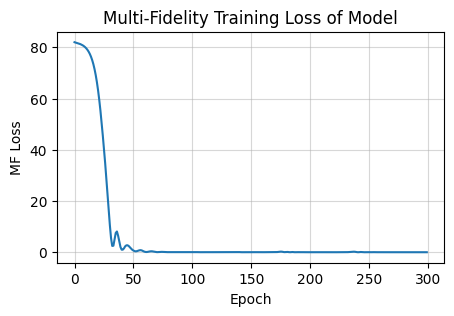

In [453]:
# percentage_errors = []

# for i in range(len(losses)):
#     abs_error = ((abs(losses[i] - val_losses[i]))/2)
#     percentage_error = (abs_error / val_losses[i]) * 100
#     percentage_errors.append(percentage_error)
    
# average_percentage_error = sum(percentage_errors) / len(percentage_errors)
# print(f"Error: {average_percentage_error}")


plt.figure(figsize=(5,3))
plt.plot(MF_losses)
plt.xlabel('Epoch')
plt.ylabel('MF Loss')
plt.title('Multi-Fidelity Training Loss of Model')
plt.grid(which='both', alpha=0.5)
print(f"MF Training Loss: {MF_loss}")

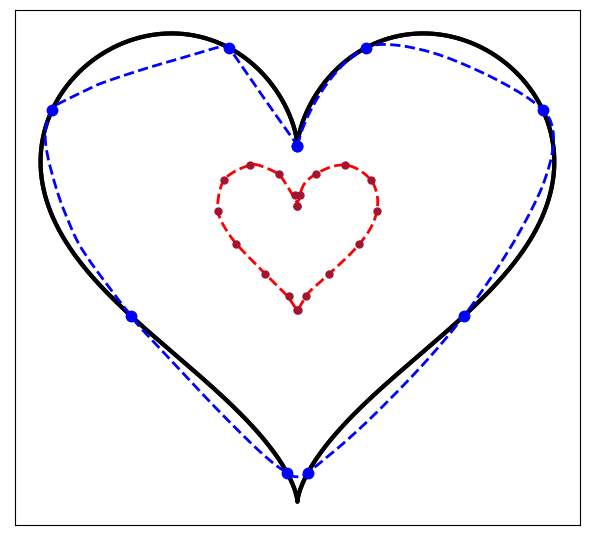

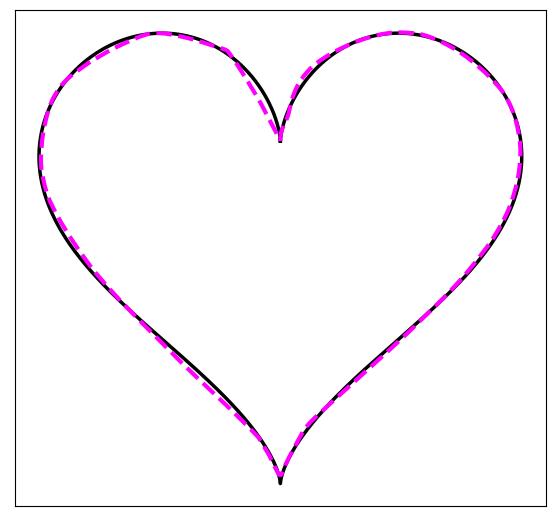

In [515]:
# Put models
LF_model.eval()
HF_model.eval()
MF_model.eval()

# Define the NEW input data
with torch.no_grad(): 
    y_LF_pred = LF_model(Z.to(device))
    y_HF_pred = HF_model(Z.to(device)) 
    
    # Step 4: Add X and output of the LF model (similar to Step 2)
    L2test = torch.hstack((Z.to(device), y_LF_pred))
    y_MF_pred = MF_model(L2test.to(device)) 
    

xL, yL = torch.split(y_LF_pred, [1, 1], dim=1)
xH, yH = torch.split(y_HF_pred, [1, 1], dim=1)
xMF, yMF = torch.split(y_MF_pred, [1, 1], dim=1)


# ###
# plt.figure(figsize=(5,3))
# plt.plot(xL.cpu().detach().numpy(), yL.cpu().detach().numpy())
# plt.plot(xH.cpu().detach().numpy(), yH.cpu().detach().numpy())
# plt.plot(xMF.cpu().detach().numpy(), yMF.cpu().detach().numpy())
# # plt.scatter(xH, yH)
###


linewidth = 3
lw = 2

# Target Lİne
Z_X, Z_Y = torch.split(HF(Z), [1, 1], dim=1)

# Low Fidelity Points and Prediction
x_lf_train, y_lf_train = torch.split(Y_LF_train, [1, 1], dim=1)

fig, ax = plt.subplots(figsize=(6,5.5))
ax.plot(Z_X, Z_Y, "k", label= "Target ", linewidth=linewidth)
ax.plot(xL.cpu().detach().numpy(), yL.cpu().detach().numpy(),"--r", lw=lw, label= "LF Prediction ",)
ax.plot(x_lf_train.cpu().detach().numpy(), y_lf_train.cpu().detach().numpy(), "o", color=(0.6350, 0.0780, 0.1840), markersize = 5, label = 'LF Data Points')

# ax.set_title('LOW Fidelity Network Predictions', fontsize=13)
ax.grid(which='both', alpha=0.2, linestyle = "--")
plt.tight_layout()
ax.set_xticklabels([]); ax.set_yticklabels([]); ax.set_xticks([]); ax.set_yticks([])
plt.savefig("LF_Plot.png", dpi=300, bbox_inches="tight")


# High Fidelity Points and Prediction
x_hf_train, y_hf_train = torch.split(Y_HF_train, [1, 1], dim=1)
ax.plot(Z_X, Z_Y, "k", label= "Target ", linewidth=linewidth)
ax.plot(xH.cpu().detach().numpy(), yH.cpu().detach().numpy(),'--b', lw=lw, label= "HF Prediction ")
ax.plot(x_hf_train.cpu().detach().numpy(), y_hf_train.cpu().detach().numpy(),"bo" , markersize = 7.5, label = 'HF Data Points')

# ax.set_title('HIGH Fidelity Network Predictions', fontsize=13)
ax.grid(which='both', alpha=0.2, linestyle = "--")
plt.tight_layout()
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_xticks([])
ax.set_yticks([])
plt.savefig("HF_Plot.png", dpi=300, bbox_inches="tight")
plt.show()

fig, ax = plt.subplots(figsize=(6,5.5))
ax.plot(Z_X, Z_Y, "k", label= "Target ", linewidth=2.5)
ax.plot(xMF.cpu().detach().numpy(), yMF.cpu().detach().numpy(),'--',color=(1, 0, 1), lw=3, label= "MF Prediction ")
plt.tight_layout()
ax.set_xticklabels([]); ax.set_yticklabels([]); ax.set_xticks([]); ax.set_yticks([]); 
plt.savefig("MF_Plot.png", dpi=300, bbox_inches="tight")
plt.show()


#! Offset data guides the HF data points to form an accurate MF prediction
#! Like testing a scaled model in a wind tunnel

In [455]:
# Data Point Distribution
# fig, ax = plt.subplots(figsize=(10,3))
# ax.plot(Z, HF(Z), label= "Target ")
# ax.grid(which='both', alpha=0.5)
# ax.set_xlabel('X', fontsize=11)
# ax.set_ylabel('Y', fontsize=11)
# ax.set_title('Low Fidelity Network Predictions', fontsize=16)
# ax.plot(Z.cpu().detach().numpy(), y_LF_pred.cpu().detach().numpy(),'--k', lw=2, label= "LF Prediction ")
# ax.plot(X_LF_train.cpu().detach().numpy(), Y_LF_train.cpu().detach().numpy(), 'ro', markersize = 3, label = 'LF Data Points')

# ax.legend(loc='upper left', ncol=1, fontsize='small')
# plt.show()


# fig, ax = plt.subplots(figsize=(10,3))
# ax.plot(Z, HF(Z), label= "Target ")
# ax.plot(Z.cpu().detach().numpy(), y_HF_pred.cpu().detach().numpy(),'--k', lw=2, label= "HF Prediction ")
# ax.plot(X_HF_train.cpu().detach().numpy(), Y_HF_train.cpu().detach().numpy(), 'bo', markersize = 4, label = 'HF Data Points')
# ax.grid(which='both', alpha=0.5)
# ax.set_xlabel('X', fontsize=11)
# ax.set_ylabel('Y', fontsize=11)
# ax.legend(loc='upper left', ncol=1, fontsize='small')

# ax.set_title('High Fidelity Network Predictions', fontsize=13)
# plt.show()


# fig, ax = plt.subplots(figsize=(10,3))
# ax.plot(Z, HF(Z), label= "Target")
# ax.plot(Z.cpu().detach().numpy(), y_MF_pred.cpu().detach().numpy(),'k', lw=2, label= "MF Prediction ")
# ax.grid(which='both', alpha=0.5)
# ax.set_xlabel('X', fontsize=11)
# ax.set_ylabel('Y', fontsize=11)
# ax.set_title('Multi Fidelity Network Prediction', fontsize=16)
# ax.legend(loc='upper left', ncol=1, fontsize='small')
# plt.show()


# # Saving Numpy Values
# np.savetxt("data/Z.txt", Z)
# np.savetxt("data/HF_Z.txt", HF(Z))
# np.savetxt("data/LF_Z.txt", LF(Z))

# np.savetxt("data/LF_PRED.txt", y_LF_pred.cpu().detach().numpy())
# np.savetxt("data/HF_PRED.txt", y_HF_pred.cpu().detach().numpy())
# np.savetxt("data/MF_PRED.txt", y_MF_pred.cpu().detach().numpy())

# np.savetxt("data/Y_LF_TRAIN.txt", Y_LF_train.cpu().detach().numpy())
# np.savetxt("data/Y_HF_TRAIN.txt", Y_HF_train.cpu().detach().numpy())
# np.savetxt("data/X_HF_TRAIN.txt", X_HF_train.cpu().detach().numpy())
# np.savetxt("data/X_LF_TRAIN.txt", X_LF_train.cpu().detach().numpy())
